In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import sqlite3
import geopandas as gpd
import geobr
import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
import libpysal
import esda
from splot.esda import moran_scatterplot
from splot.esda import lisa_cluster
from splot.libpysal import plot_spatial_weights  # plota os pesos
import math                                      # Raiz quadrada e funções trigonométricas
import csv                                       # Escrever CSVs


# Define Bases

In [2]:
indicadores_db = "///media//pedro//HD Externo//Teste//cidades//indicadores.db"
BASE = 'bases'
LOCAL = "I_local//"
GLOBAL = "I_global//"
pop2020 = BASE + "pop2020.csv"
ri = BASE + "regioes_geograficas_composicao_por_municipios_2017_20180911.csv"

In [3]:
csv_df = pd.read_csv(ri, delimiter=';')
csv_df.rename(columns={'CD_GEOCODI':'city_ibge_code', 'nome_mun':'city','nome_rgi':'imediate_reg', 'cod_rgi':'imed_reg_code'}, inplace=True)
csv_df = csv_df[['city_ibge_code','imediate_reg','imed_reg_code' ]].copy()
csv_df = csv_df.sort_values(by=['imed_reg_code']).copy()
csv_df['city_ibge_code'] = csv_df['city_ibge_code'].astype('int')

pop_df = pd.read_csv(pop2020, index_col=0)
pop_df.rename(columns={'Total':'total_inhabitants','Armenor':'city_ibge_code'},  inplace = True)
pop_df['city_ibge_code'] = pop_df['city_ibge_code'].astype('int')
pop_df = pd.merge(csv_df, pop_df,on='city_ibge_code', how='inner')


In [4]:
#csv_df  #completo
#pop_df  #completo

In [5]:
pop_reg = pop_df[['imed_reg_code', 'total_inhabitants']].copy()
pop_reg = pop_reg.groupby(pop_reg['imed_reg_code']).sum().reset_index()


In [6]:
#pop_reg  completo

In [7]:
#Leitura dos indicadores por região imediata
cnx = sqlite3.connect(indicadores_db)
cur = cnx.cursor()
regimed_df = pd.read_sql_query("SELECT * FROM imedreg_df", cnx)


In [8]:
#Leitura da geometrias das regiões e merge com os indicadores
ri_geo = geobr.read_immediate_region()
ri_geo = ri_geo.rename(columns={'code_immediate':'imed_reg_code'})
ri_geo['imed_reg_code'] = ri_geo['imed_reg_code'].astype(int)
ri_geo = ri_geo.merge(regimed_df, on = 'imed_reg_code')

base = ri_geo[ri_geo['epidemiological_week'] == 202036]
base = pd.merge(base, pop_reg, on='imed_reg_code', how='inner')
base = base.rename(columns={'total_inhabitants_y':'total_inhabitants'})

/home/pedro/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [9]:
#ri_geo   completo
#base     completo

In [10]:
reg_code = base['imed_reg_code'].values.tolist()
imedreg = base['name_immediate'].values.tolist()
regions = base['region'].values.tolist()
pop = base['total_inhabitants'].values.tolist()

semana = 202046

str_sem = semana

#Alterar aqui para mudar a semana analisada
sem = ri_geo[ri_geo['epidemiological_week'] == semana]

#Cálculo do peso entre regiões
weights = Queen.from_dataframe(sem)
weights.transform = 'r'


#Consertando os erros causados pela digitalização
wnp = libpysal.weights.util.nonplanar_neighbors(weights, sem)
wnp.transform = 'r'

#Calcular spatial_auto
spatial_auto = esda.Moran_Local(sem['incidence_cases'], wnp, permutations=100000)
moran = esda.Moran(sem['incidence_cases'], wnp)

#I_local
local_Is = spatial_auto.Is
list_Is = local_Is.tolist()

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [11]:
#lisa_cluster(spatial_auto, sem, p=0.05, figsize = (20,15))

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>)

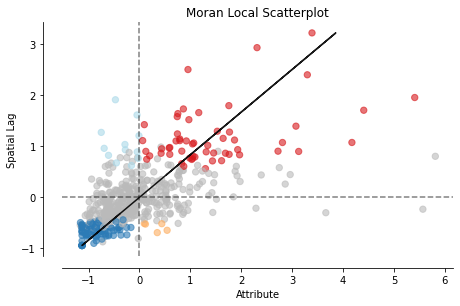

In [12]:

## Visualização do moran
moran_scatterplot(spatial_auto, p=0.05)

In [13]:
## Cálculo do lag espacial e incidencia espacial normalizados

lag = libpysal.weights.spatial_lag.lag_spatial(wnp, sem['incidence_cases'])



norm_lag = ( lag - lag.mean() )\
                   / lag.std()

norm_incid = (sem['incidence_cases'] - sem['incidence_cases'].mean())\
                /sem['incidence_cases'].std()
norm_incid = norm_incid.tolist()


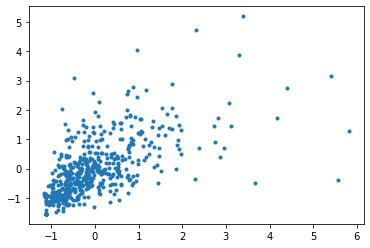

In [14]:
## Visuzalição da recosntrução do scatterplot de moran

plt.plot(norm_incid, norm_lag, '.')

plt.show()

In [15]:
## Separando apenas os pontos significativos

sim_norm_incid = []
sim_norm_lag = []
points = []
cluster = spatial_auto.q.tolist()

for i, auto in enumerate(spatial_auto.p_sim):
    
    sim = int(auto < 0.05)
    sim_norm_incid.append(norm_incid[i] * sim)
    sim_norm_lag.append(norm_lag[i] * sim)
    points.append([sim_norm_incid[i],sim_norm_lag[i]])
    cluster[i] = cluster[i] * sim 



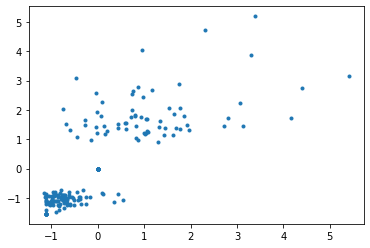

In [16]:
plt.plot(sim_norm_incid, sim_norm_lag, '.')

plt.show()

In [17]:
## Escrevendo os pontos como vetores em função do módulo e direção

vetores = []

for i, point in enumerate(points):
    x = point[0]
    y = point[1]
    if x == 0:
        if y < 0: 
            ang = 3 * (math.pi / 2)
        else:
            ang = (math.pi / 2) 

    elif x * y > 0:
        ang = math.atan(y/x) + (math.pi * int(y < 0)) 
    else: 
        ang = math.atan(y/x) + math.pi * (int(y < 0) + 1)
        
    mod = math.sqrt(x*x + y*y)
    if mod < 0:
        print(mod)

    
    vetores.append([ang])
    vetores[i].append(mod)


In [18]:

# conferindo os resultados
for i, point in enumerate(points):


    x = round(point[0], 3)
    y = round(point[1], 3)
    x_est = round(math.cos(vetores[i][0]) * vetores[i][1], 3)
    y_est = round(math.sin(vetores[i][0]) * vetores[i][1], 3)
    if x != x_est or y != y_est:
        print(x, y, x_est, y_est, vetores[i])
        
    mod = vetores[i][1]
    
    
    if x > 0 and x * y > 0 and cluster[i] != 1:
        print (x, y, mod, cluster[i])
    elif x < 0 and x * y > 0 and cluster[i] != 3:
        print (x, y, mod, cluster[i])
    elif x > 0 and x * y < 0 and cluster[i] != 4:
        print (x, y, mod, cluster[i])
    elif x < 0 and x * y < 0 and cluster[i] != 2:
        print (x, y, mod, cluster[i])
    elif mod > 0 and cluster[i] == 0:
        print (x, y, mod, cluster[i])
    elif mod == 0 and cluster[i] != 0:
        print (x, y, mod, cluster[i])
    elif mod < 0:
        print (x, y, mod, cluster[i])
    

In [20]:
with open('imedreg_I_local.csv', 'w', encoding='utf-8', newline='') as lista:
    writer = csv.writer(lista)
    
    writer.writerow(("imedreg", "imedreg_code", "populacao", "incidencia_normalizada", "regiao", 'cluster'))

    for i in range(510):
        writer.writerow((imedreg[i], reg_code[i], pop[i], norm_incid[i], regions[i], cluster[i]))

In [22]:
semanas = {202048, 202049, 202050, 202051, 202052, 202053, 202101, 202102, 202103, 202104, 202105, 202106, 202107, 202108, 202109, 202110, 202111}
semanas_1 = {202016, 202017, 202018, 202019, 202020, 202021, 202022, 202023, 202024, 202025, 202026, 202027, 202028, 202029, 202030, 202031, 202032}
semanas_totais = {*semanas,*semanas_1}

In [23]:
imedreg = base['name_immediate'].values.tolist()
reg_code = base['imed_reg_code'].values.tolist()
region = base['region'].values.tolist()
pop = base['total_inhabitants'].values.tolist()


indicadores = ['prevalence', 'incidence_cases', 'lethality']

for indicador in indicadores:
    I_global_vet = []
    for semana in semanas_totais:

        #Alterar aqui para mudar a semana analisada
        sem = ri_geo[ri_geo['epidemiological_week'] == semana]


        #Cálculo do peso entre regiões
        weights = Queen.from_dataframe(sem)
        weights.transform = 'r'


        #Consertando os erros causados pela digitalização
        wnp = libpysal.weights.util.nonplanar_neighbors(weights, sem)
        wnp.transform = 'r'

        #Calcular spatial_auto
        moran = esda.Moran(sem[indicador], wnp, permutations=100000)
        I_global_vet.append(moran.I)

    print(indicador + 'calculado')
    with open(GLOBAL + 'Is_globais_' + indicador + '.csv', 'w', encoding='utf-8', newline='') as lista:
        writer = csv.writer(lista)

        writer.writerow(('semana', 'I_global'))

        for i, semana in enumerate(semanas_totais):
            writer.writerow((semana, I_global_vet[i]))
    
    print(indicador + 'escrito')

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


prevalencecalculado
prevalenceescrito


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


incidence_casescalculado
incidence_casesescrito


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


lethalitycalculado
lethalityescrito


In [24]:
imedreg = base['name_immediate'].values.tolist()
reg_code = base['imed_reg_code'].values.tolist()
region = base['region'].values.tolist()
pop = base['total_inhabitants'].values.tolist()

for semana in semanas_1:
    str_sem = str(semana)

    
    #Alterar aqui para mudar a semana analisada
    sem = ri_geo[ri_geo['epidemiological_week'] == semana]

    
    #Cálculo do peso entre regiões
    weights = Queen.from_dataframe(sem)
    weights.transform = 'r'


    #Consertando os erros causados pela digitalização
    wnp = libpysal.weights.util.nonplanar_neighbors(weights, sem)
    wnp.transform = 'r'

    #Calcular spatial_auto
    spatial_auto = esda.Moran_Local(sem['incidence_cases'], wnp, permutations=100000)
    moran = esda.Moran(sem['incidence_cases'], wnp)

    
    
    #I_local
    local_Is = spatial_auto.Is
    list_Is = local_Is.tolist()
    
    
    
    ## Cálculo do lag espacial e incidencia espacial normalizados
    lag = libpysal.weights.spatial_lag.lag_spatial(wnp, sem['incidence_cases'])
    norm_lag = ( lag - lag.mean() )\
                       / lag.std()

    norm_incid = (sem['incidence_cases'] - sem['incidence_cases'].mean())\
                    /sem['incidence_cases'].std()
    norm_incid = norm_incid.tolist()

    
    
    ## Separando apenas os pontos significativos
    sim_norm_incid = []
    sim_norm_lag = []
    points = []
    cluster = spatial_auto.q.tolist()

    for i, auto in enumerate(spatial_auto.p_sim):
        sim = int(auto < 0.05)
        sim_norm_incid.append(norm_incid[i] * sim)
        sim_norm_lag.append(norm_lag[i] * sim)
        points.append([sim_norm_incid[i],sim_norm_lag[i]])
        cluster[i] = cluster[i] * sim 



        
    ## Escrevendo os pontos como vetores em função do módulo e direção
    vetores = []

    for i, point in enumerate(points):
        x = point[0]
        y = point[1]
        if x == 0:
            if y < 0: 
                ang = 3 * (math.pi / 2)
            else:
                ang = (math.pi / 2) 
                
        elif x * y > 0:
            ang = math.atan(y/x) + (math.pi * int(y < 0)) 
        else: 
            ang = math.atan(y/x) + math.pi * (int(y < 0) + 1)

        mod = math.sqrt(x*x + y*y)
        if mod < 0:
            print(mod)
            break
        vetores.append([ang])
        vetores[i].append(mod)


       
    # conferindo os resultados
    for i, point in enumerate(points):


        x = round(point[0], 3)
        y = round(point[1], 3)
        x_est = round(math.cos(vetores[i][0]) * vetores[i][1], 3)
        y_est = round(math.sin(vetores[i][0]) * vetores[i][1], 3)
        if x != x_est or y != y_est:
            print(x, y, x_est, y_est, vetores[i])

        mod = vetores[i][1]


        if x > 0 and x * y > 0 and cluster[i] != 1:
            print (x, y, mod, cluster[i])
            break
        elif x < 0 and x * y > 0 and cluster[i] != 3:
            print (x, y, mod, cluster[i])
            break
        elif x > 0 and x * y < 0 and cluster[i] != 4:
            print (x, y, mod, cluster[i])
            break
        elif x < 0 and x * y < 0 and cluster[i] != 2:
            print (x, y, mod, cluster[i])
            break
        elif mod > 0 and cluster[i] == 0:
            print (x, y, mod, cluster[i])
            break
        elif mod == 0 and cluster[i] != 0:
            print (x, y, mod, cluster[i])
            break
        elif mod < 0:
            print (x, y, mod, cluster[i])
            break


    
        
    #Escreve CSV
    with open(LOCAL + 'imedreg_incidencia_' + str_sem + '.csv', 'w', encoding='utf-8', newline='') as lista:
        writer = csv.writer(lista)

        writer.writerow(("imedreg", "imedreg_code" "populacao", "incidencia_normalizada", "regiao", 'cluster'))

        for i in range(510):
            writer.writerow((imedreg[i], reg_code[i], pop[i], norm_incid[i], region[i], cluster[i]))
            

            

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [25]:
imedreg = base['name_immediate'].values.tolist()
reg_code = base['imed_reg_code'].values.tolist()
region = base['region'].values.tolist()
pop = base['total_inhabitants'].values.tolist()

for semana in semanas_1:
    str_sem = str(semana)

    
    #Alterar aqui para mudar a semana analisada
    sem = ri_geo[ri_geo['epidemiological_week'] == semana]

    
    #Cálculo do peso entre regiões
    weights = Queen.from_dataframe(sem)
    weights.transform = 'r'


    #Consertando os erros causados pela digitalização
    wnp = libpysal.weights.util.nonplanar_neighbors(weights, sem)
    wnp.transform = 'r'

    #Calcular spatial_auto
    spatial_auto = esda.Moran_Local(sem['prevalence'], wnp, permutations=100000)
    moran = esda.Moran(sem['prevalence'], wnp)

    
    
    #I_local
    local_Is = spatial_auto.Is
    list_Is = local_Is.tolist()
    
    
    
    ## Cálculo do lag espacial e incidencia espacial normalizados
    lag = libpysal.weights.spatial_lag.lag_spatial(wnp, sem['prevalence'])
    norm_lag = ( lag - lag.mean() )\
                       / lag.std()

    norm_incid = (sem['prevalence'] - sem['prevalence'].mean())\
                    /sem['prevalence'].std()
    norm_incid = norm_incid.tolist()

    
    
    ## Separando apenas os pontos significativos
    sim_norm_incid = []
    sim_norm_lag = []
    points = []
    cluster = spatial_auto.q.tolist()

    for i, auto in enumerate(spatial_auto.p_sim):
        sim = int(auto < 0.05)
        sim_norm_incid.append(norm_incid[i] * sim)
        sim_norm_lag.append(norm_lag[i] * sim)
        points.append([sim_norm_incid[i],sim_norm_lag[i]])
        cluster[i] = cluster[i] * sim 



        
    ## Escrevendo os pontos como vetores em função do módulo e direção
    vetores = []

    for i, point in enumerate(points):
        x = point[0]
        y = point[1]
        if x == 0:
            if y < 0: 
                ang = 3 * (math.pi / 2)
            else:
                ang = (math.pi / 2) 
                
        elif x * y > 0:
            ang = math.atan(y/x) + (math.pi * int(y < 0)) 
        else: 
            ang = math.atan(y/x) + math.pi * (int(y < 0) + 1)

        mod = math.sqrt(x*x + y*y)
        if mod < 0:
            print(mod)
            break
        vetores.append([ang])
        vetores[i].append(mod)


       
    # conferindo os resultados
    for i, point in enumerate(points):


        x = round(point[0], 3)
        y = round(point[1], 3)
        x_est = round(math.cos(vetores[i][0]) * vetores[i][1], 3)
        y_est = round(math.sin(vetores[i][0]) * vetores[i][1], 3)
        if x != x_est or y != y_est:
            print(x, y, x_est, y_est, vetores[i])

        mod = vetores[i][1]


        if x > 0 and x * y > 0 and cluster[i] != 1:
            print (x, y, mod, cluster[i])
            break
        elif x < 0 and x * y > 0 and cluster[i] != 3:
            print (x, y, mod, cluster[i])
            break
        elif x > 0 and x * y < 0 and cluster[i] != 4:
            print (x, y, mod, cluster[i])
            break
        elif x < 0 and x * y < 0 and cluster[i] != 2:
            print (x, y, mod, cluster[i])
            break
        elif mod > 0 and cluster[i] == 0:
            print (x, y, mod, cluster[i])
            break
        elif mod == 0 and cluster[i] != 0:
            print (x, y, mod, cluster[i])
            break
        elif mod < 0:
            print (x, y, mod, cluster[i])
            break


    
        
    #Escreve CSV
    with open(LOCAL + 'imedreg_prevalencia_' + str_sem + '.csv', 'w', encoding='utf-8', newline='') as lista:
        writer = csv.writer(lista)

        writer.writerow(("imedreg", "imedreg_code" "populacao", "prevalencia_normalizada", "regiao", 'cluster'))

        for i in range(510):
            writer.writerow((imedreg[i], reg_code[i], pop[i], norm_incid[i], region[i], cluster[i]))
            


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [26]:
imedreg = base['name_immediate'].values.tolist()
reg_code = base['imed_reg_code'].values.tolist()
region = base['region'].values.tolist()
pop = base['total_inhabitants'].values.tolist()

for semana in semanas_1:
    str_sem = str(semana)

    
    #Alterar aqui para mudar a semana analisada
    sem = ri_geo[ri_geo['epidemiological_week'] == semana]

    
    #Cálculo do peso entre regiões
    weights = Queen.from_dataframe(sem)
    weights.transform = 'r'


    #Consertando os erros causados pela digitalização
    wnp = libpysal.weights.util.nonplanar_neighbors(weights, sem)
    wnp.transform = 'r'

    #Calcular spatial_auto
    spatial_auto = esda.Moran_Local(sem['lethality'], wnp, permutations=100000)
    moran = esda.Moran(sem['lethality'], wnp)

    
    
    #I_local
    local_Is = spatial_auto.Is
    list_Is = local_Is.tolist()
    
    
    
    ## Cálculo do lag espacial e incidencia espacial normalizados
    lag = libpysal.weights.spatial_lag.lag_spatial(wnp, sem['lethality'])
    norm_lag = ( lag - lag.mean() )\
                       / lag.std()

    norm_incid = (sem['lethality'] - sem['lethality'].mean())\
                    /sem['lethality'].std()
    norm_incid = norm_incid.tolist()

    
    
    ## Separando apenas os pontos significativos
    sim_norm_incid = []
    sim_norm_lag = []
    points = []
    cluster = spatial_auto.q.tolist()

    for i, auto in enumerate(spatial_auto.p_sim):
        sim = int(auto < 0.05)
        sim_norm_incid.append(norm_incid[i] * sim)
        sim_norm_lag.append(norm_lag[i] * sim)
        points.append([sim_norm_incid[i],sim_norm_lag[i]])
        cluster[i] = cluster[i] * sim 



        
    ## Escrevendo os pontos como vetores em função do módulo e direção
    vetores = []

    for i, point in enumerate(points):
        x = point[0]
        y = point[1]
        if x == 0:
            if y < 0: 
                ang = 3 * (math.pi / 2)
            else:
                ang = (math.pi / 2) 
                
        elif x * y > 0:
            ang = math.atan(y/x) + (math.pi * int(y < 0)) 
        else: 
            ang = math.atan(y/x) + math.pi * (int(y < 0) + 1)

        mod = math.sqrt(x*x + y*y)
        if mod < 0:
            print(mod)
            break
        vetores.append([ang])
        vetores[i].append(mod)


       
    # conferindo os resultados
    for i, point in enumerate(points):


        x = round(point[0], 3)
        y = round(point[1], 3)
        x_est = round(math.cos(vetores[i][0]) * vetores[i][1], 3)
        y_est = round(math.sin(vetores[i][0]) * vetores[i][1], 3)
        if x != x_est or y != y_est:
            print(x, y, x_est, y_est, vetores[i])

        mod = vetores[i][1]


        if x > 0 and x * y > 0 and cluster[i] != 1:
            print (x, y, mod, cluster[i])
            break
        elif x < 0 and x * y > 0 and cluster[i] != 3:
            print (x, y, mod, cluster[i])
            break
        elif x > 0 and x * y < 0 and cluster[i] != 4:
            print (x, y, mod, cluster[i])
            break
        elif x < 0 and x * y < 0 and cluster[i] != 2:
            print (x, y, mod, cluster[i])
            break
        elif mod > 0 and cluster[i] == 0:
            print (x, y, mod, cluster[i])
            break
        elif mod == 0 and cluster[i] != 0:
            print (x, y, mod, cluster[i])
            break
        elif mod < 0:
            print (x, y, mod, cluster[i])
            break


    
        
    #Escreve CSV
    with open(LOCAL + 'imedreg_letalidade_' + str_sem + '.csv', 'w', encoding='utf-8', newline='') as lista:
        writer = csv.writer(lista)

        writer.writerow(("imedreg", "imedreg_code" "populacao", "letalidade_normalizada", "regiao", 'cluster'))

        for i in range(510):
            writer.writerow((imedreg[i], reg_code[i], pop[i], norm_incid[i], region[i], cluster[i]))
            


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


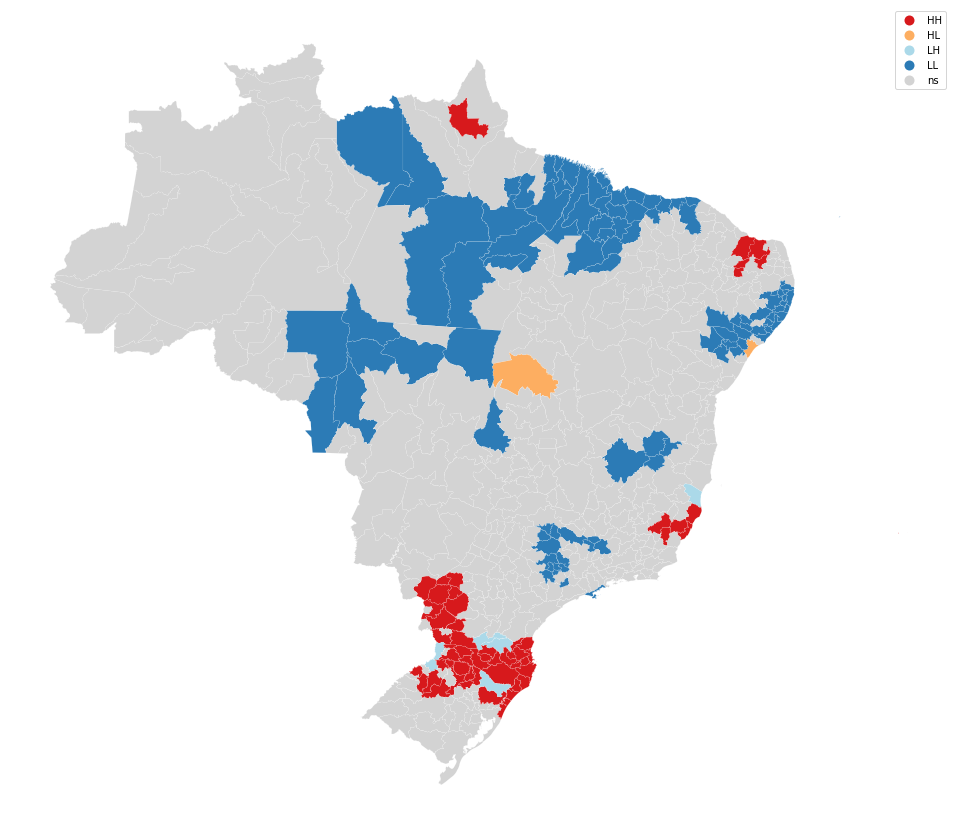

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


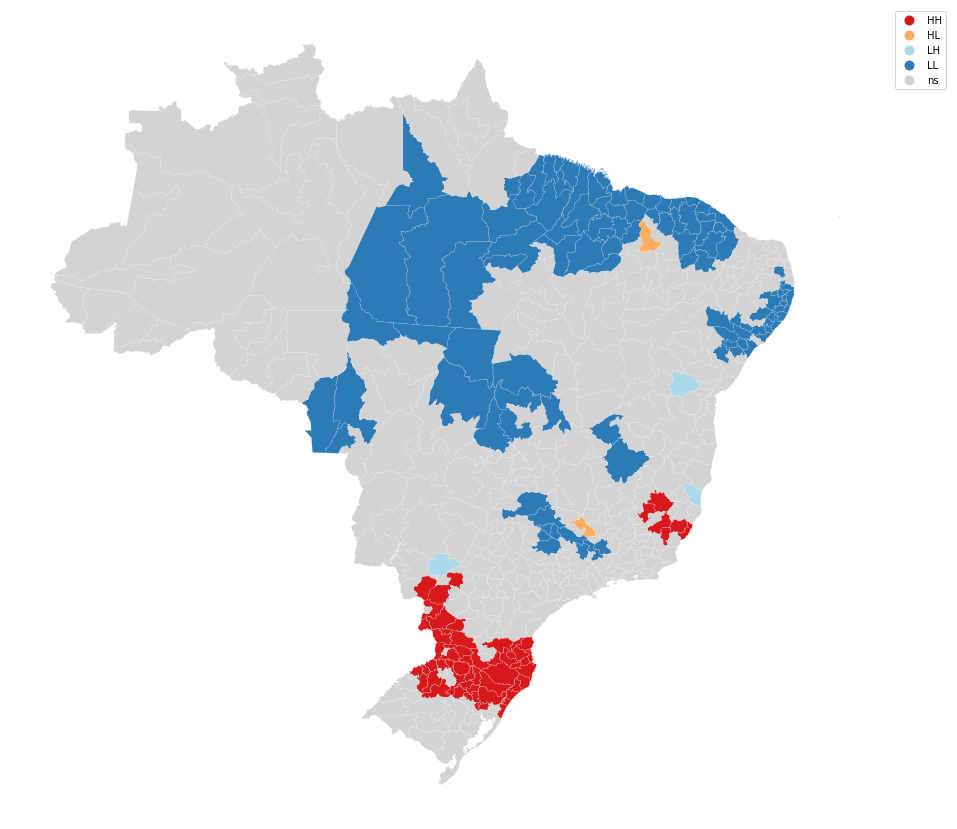

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


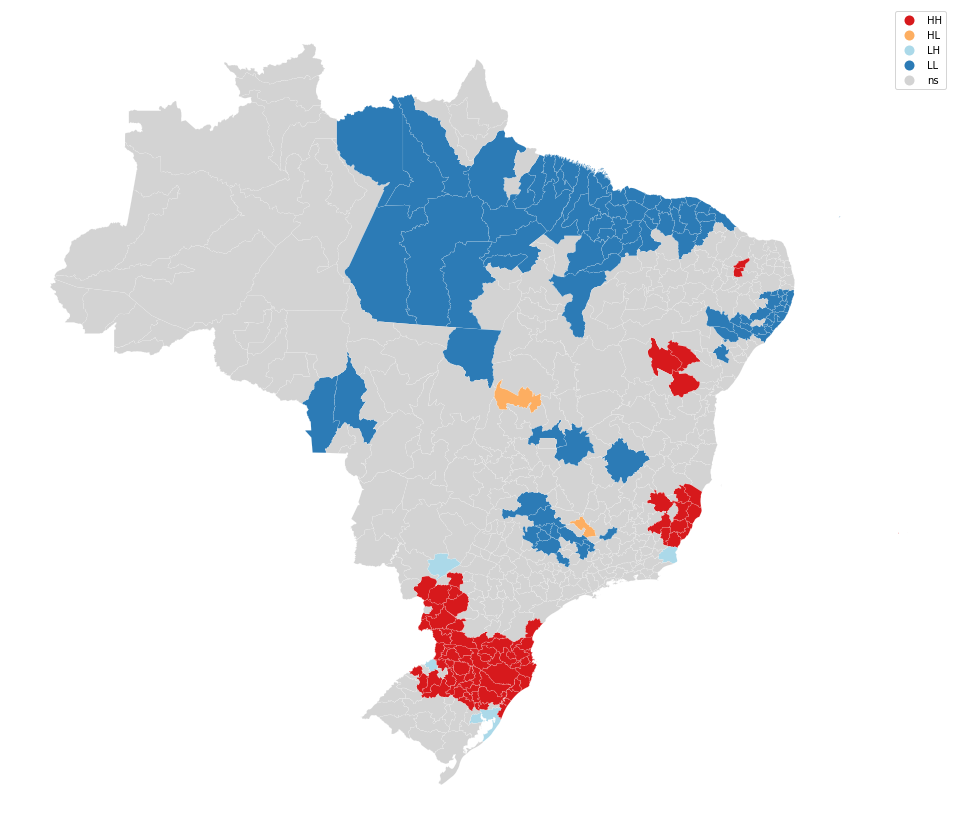

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


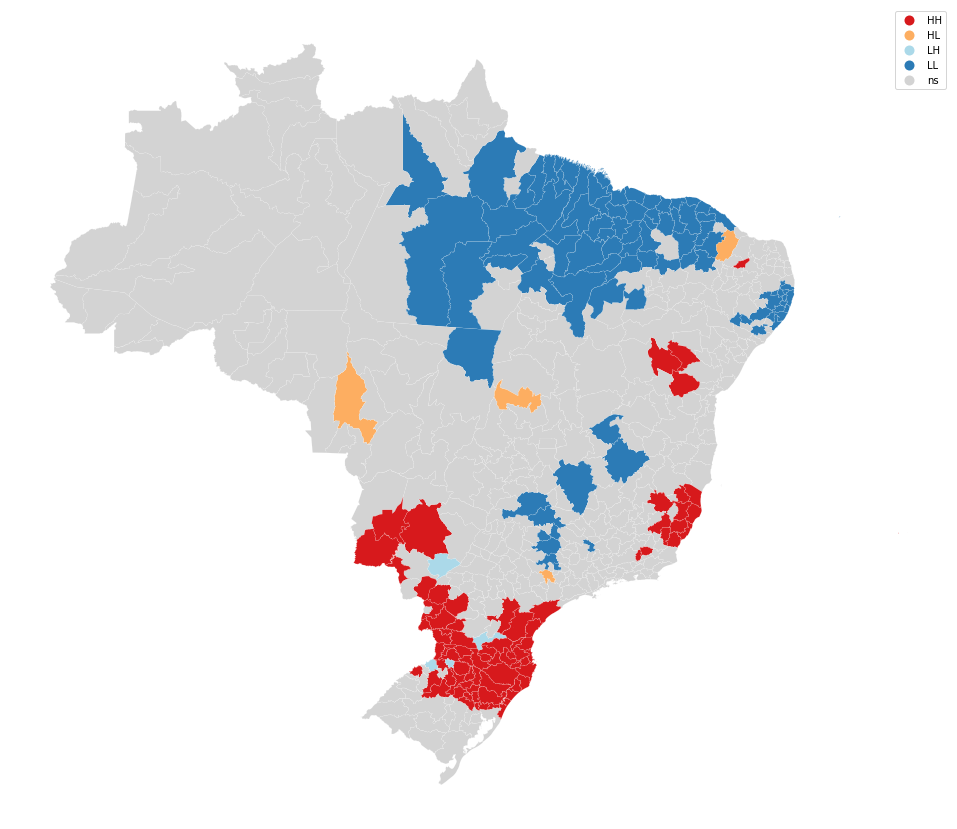

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


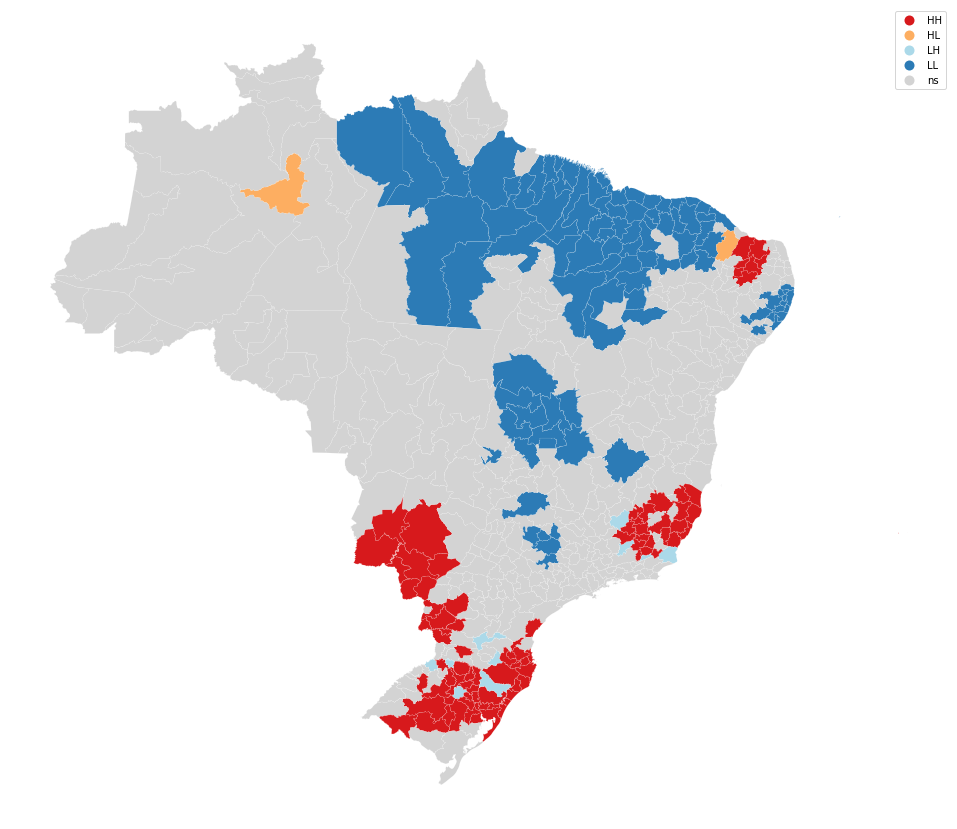

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


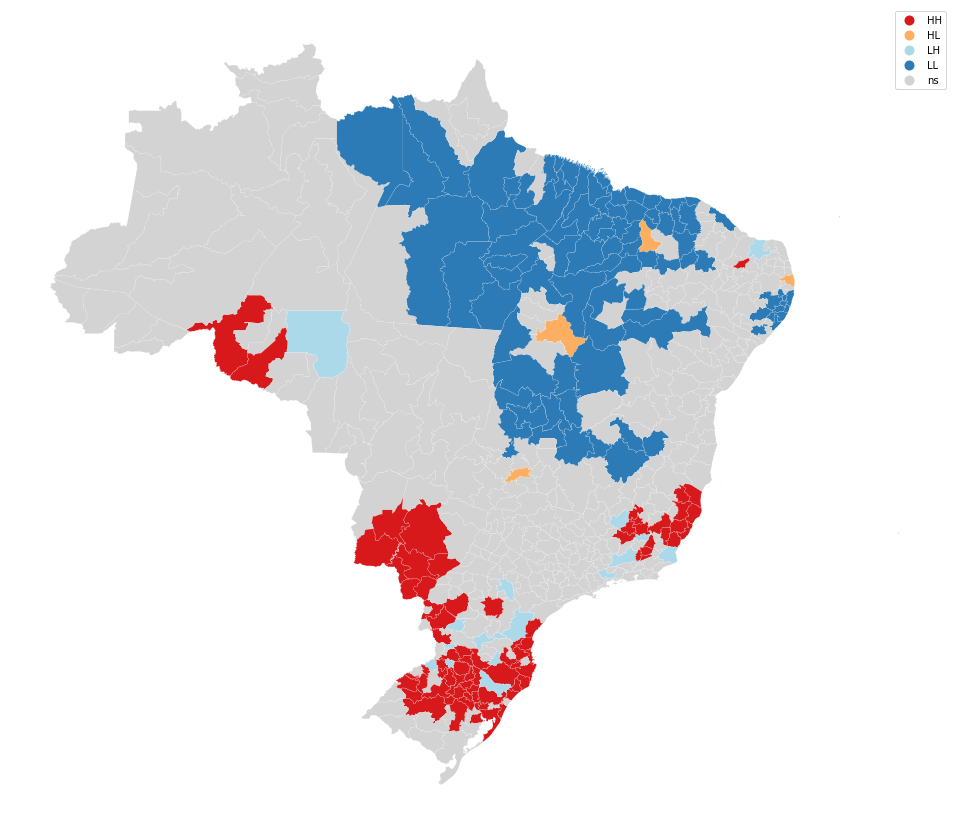

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


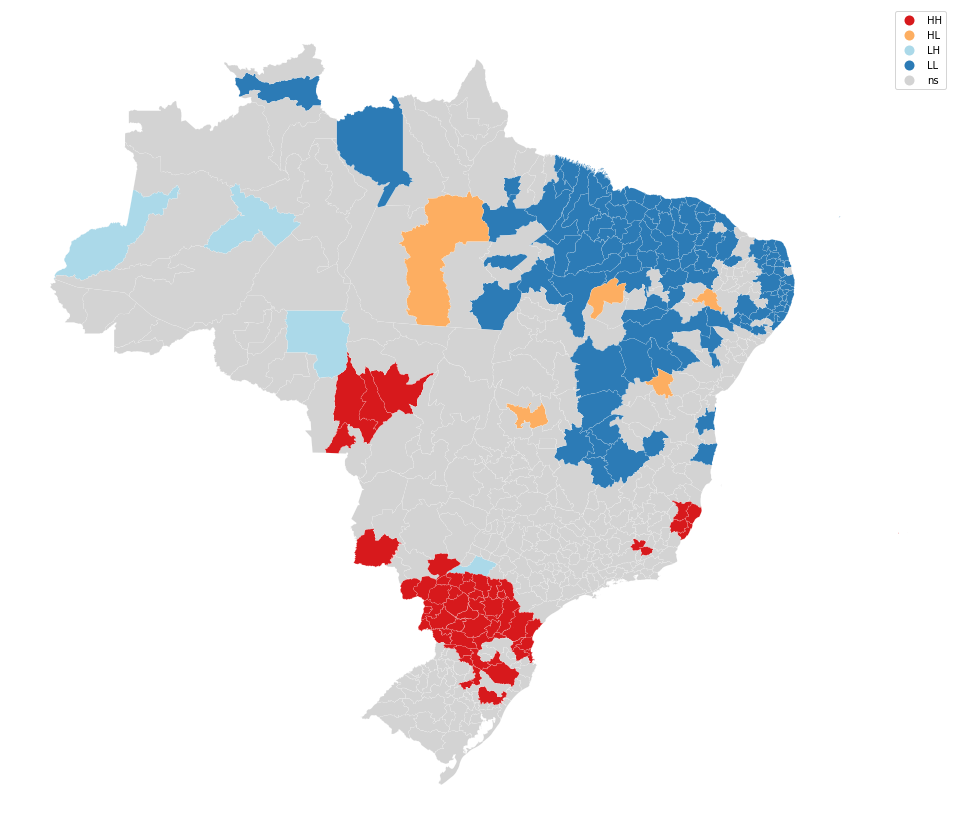

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


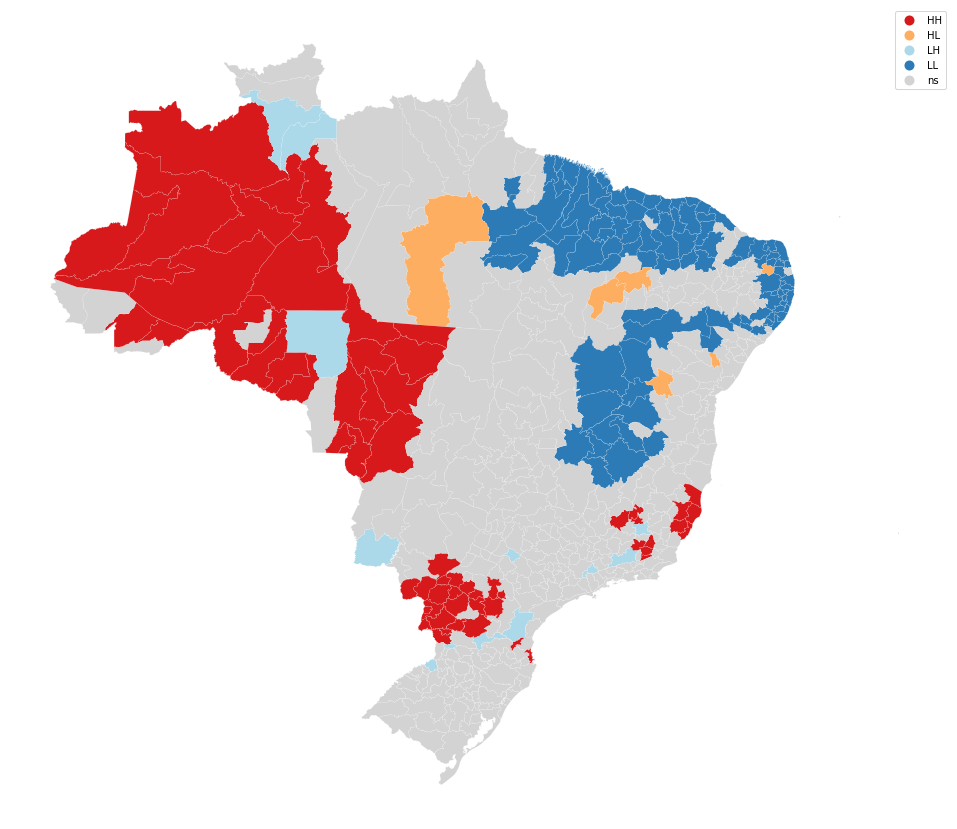

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


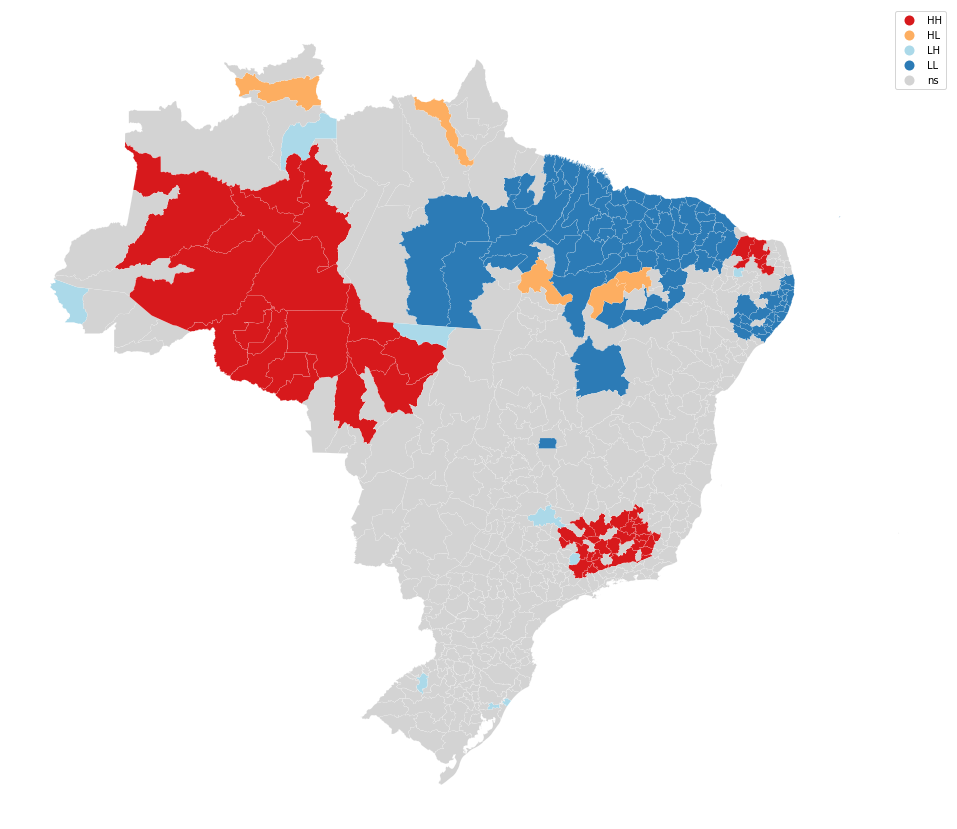

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


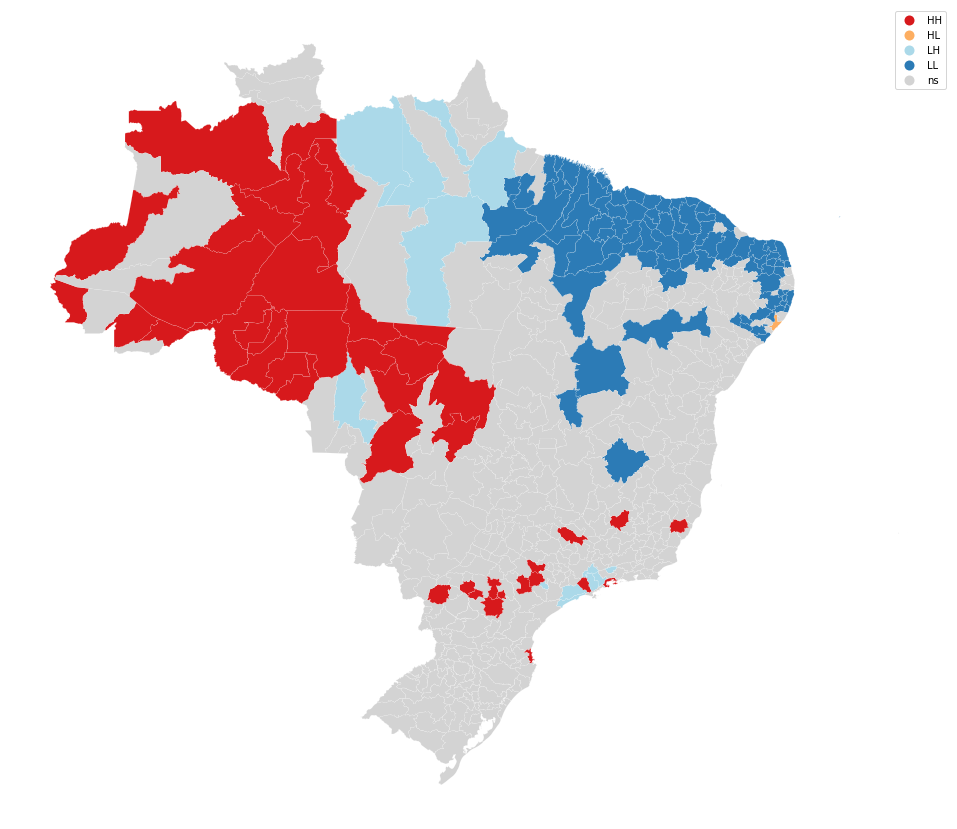

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


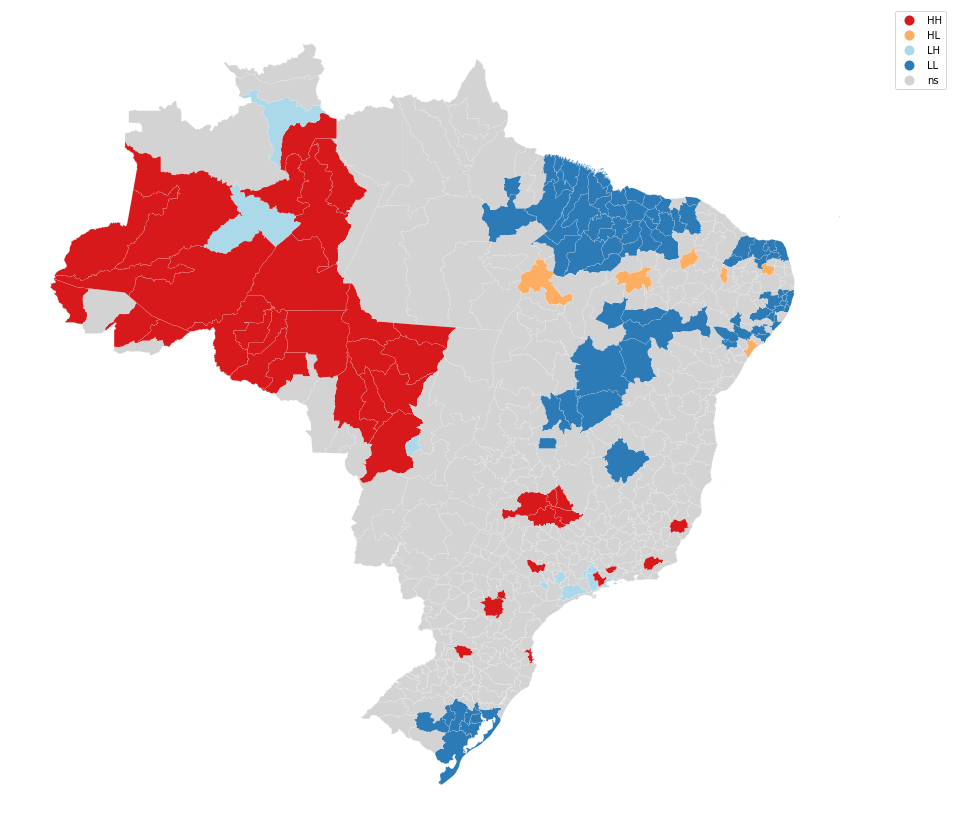

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


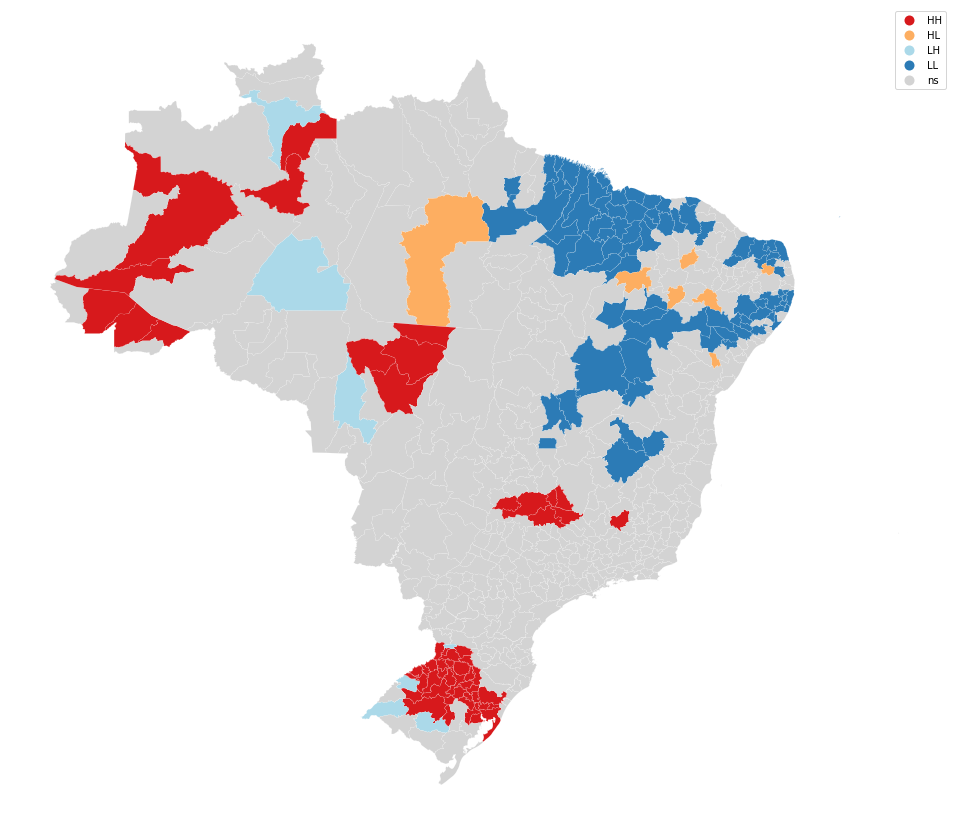

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


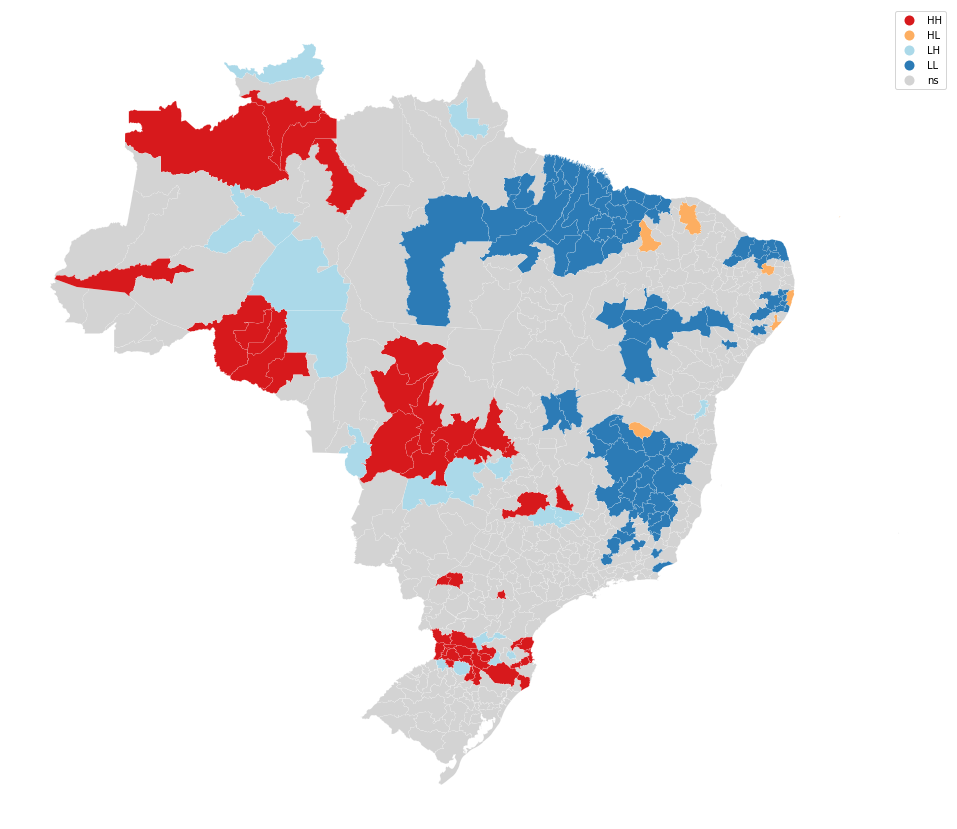

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


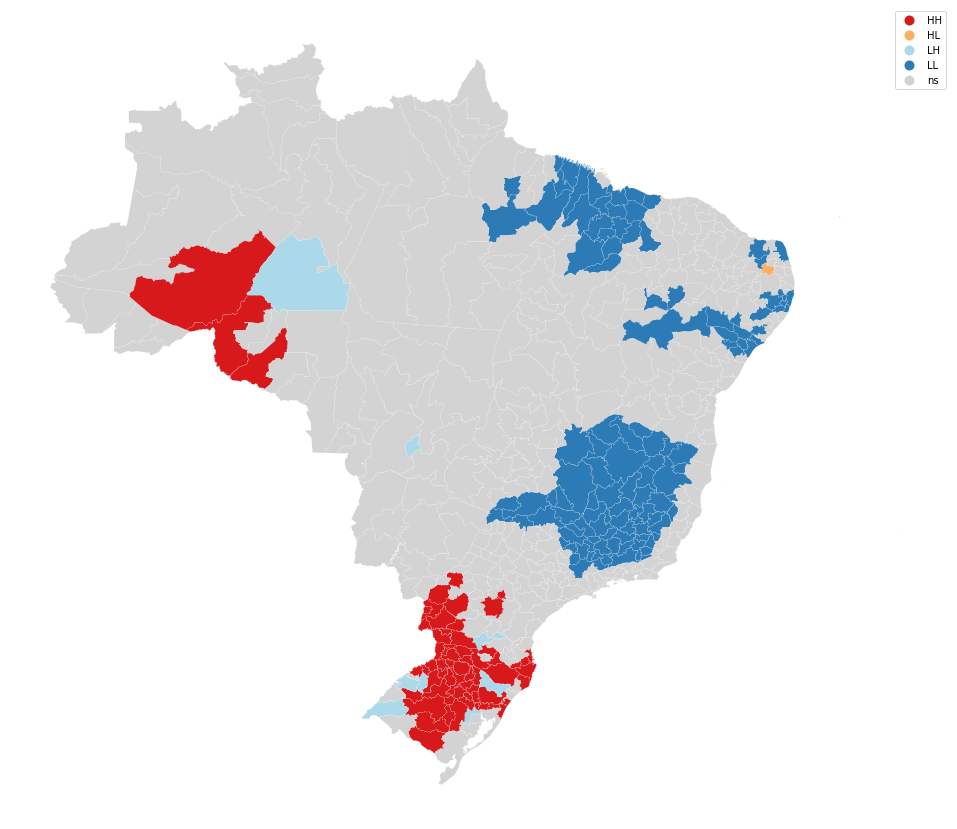

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


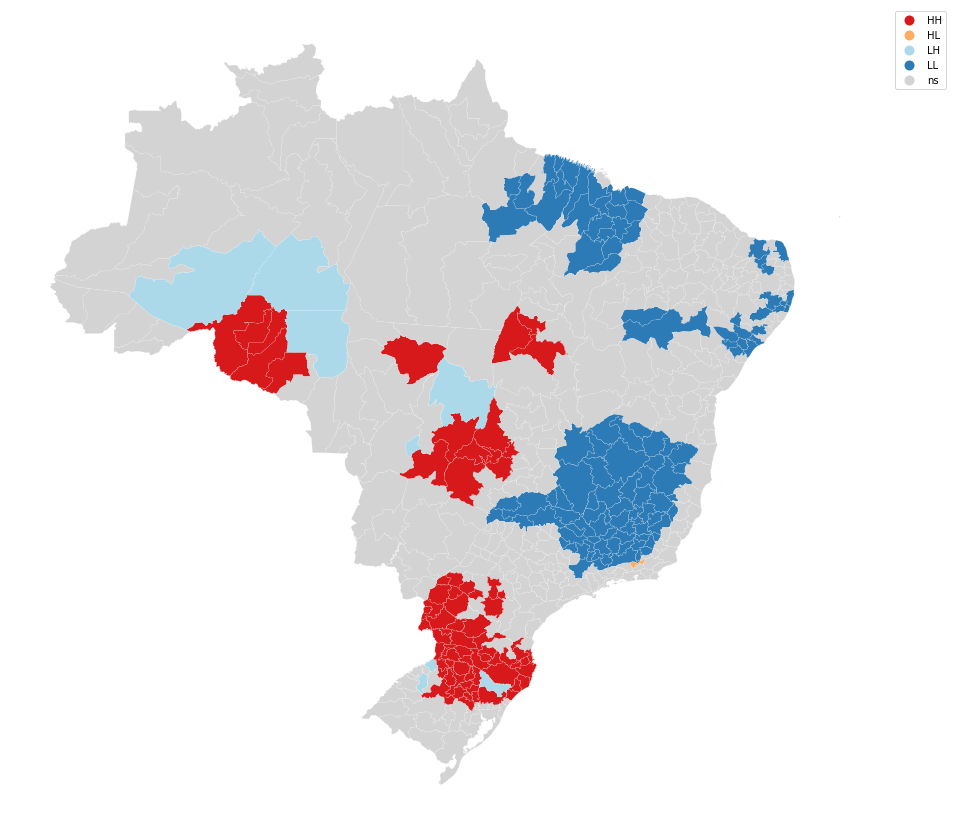

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


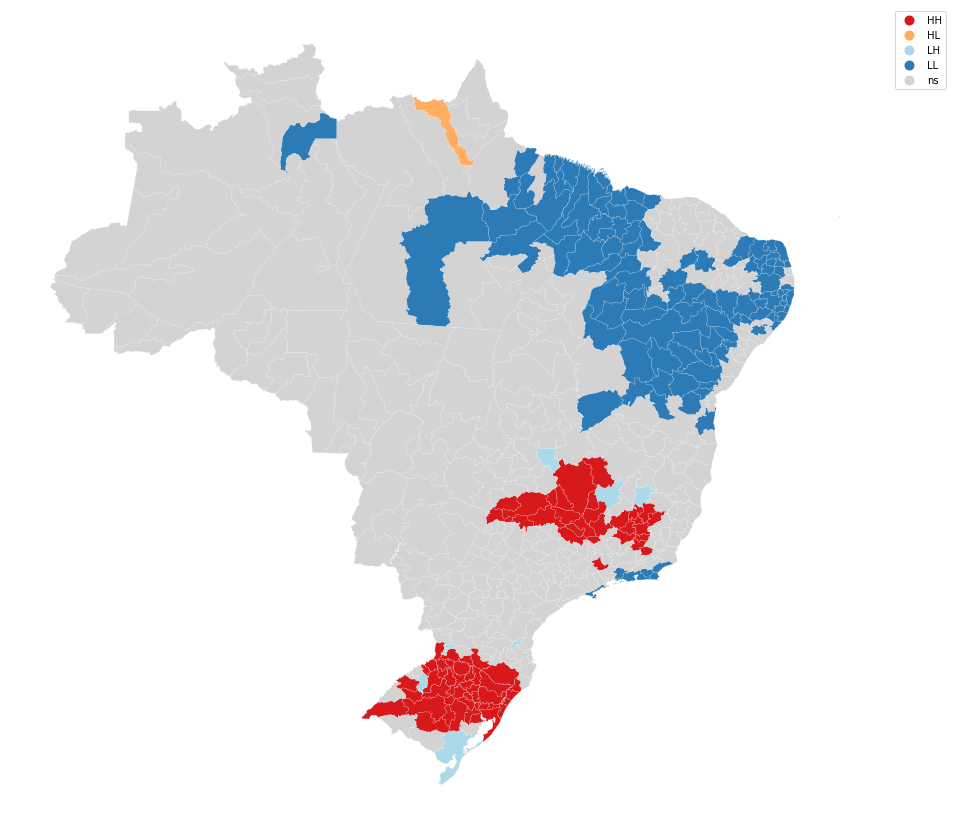

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


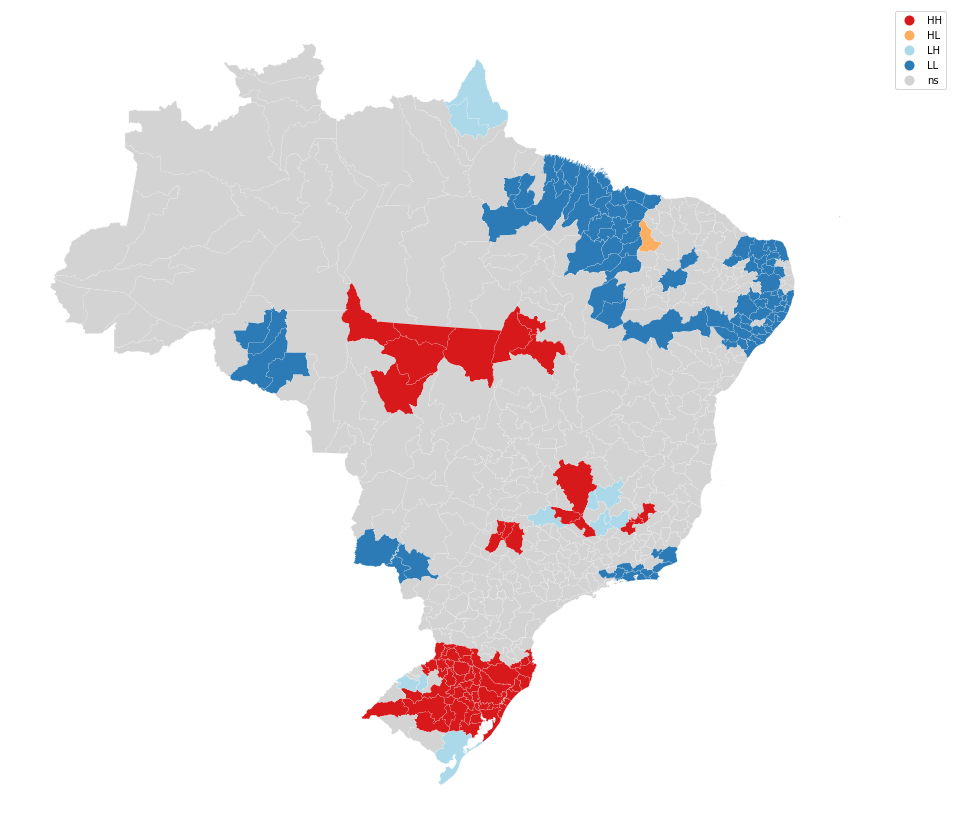

In [27]:
for semana in semanas:
    str_sem = str(semana)

    
    #Alterar aqui para mudar a semana analisada
    sem = ri_geo[ri_geo['epidemiological_week'] == semana]

    
    #Cálculo do peso entre regiões
    weights = Queen.from_dataframe(sem)
    weights.transform = 'r'


    #Consertando os erros causados pela digitalização
    wnp = libpysal.weights.util.nonplanar_neighbors(weights, sem)
    wnp.transform = 'r'

    #Calcular spatial_auto
    spatial_auto = esda.Moran_Local(sem['incidence_cases'], wnp, permutations=100000)
    moran = esda.Moran(sem['incidence_cases'], wnp)
    
    lisa_cluster(spatial_auto, sem, p=0.05, figsize = (20,15))
    plt.show()